In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [29]:
# reflect an existing database into a new model using 'autpmap_base()'
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [30]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [33]:
# Print column names and types for Station table
print(Station.__table__.columns.keys())


['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [34]:
# Print column names and types for Measurement table
print(Measurement.__table__.columns.keys())


['id', 'station', 'date', 'prcp', 'tobs']


# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set; return date as datetime object
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
stroptime = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')


2016-08-23


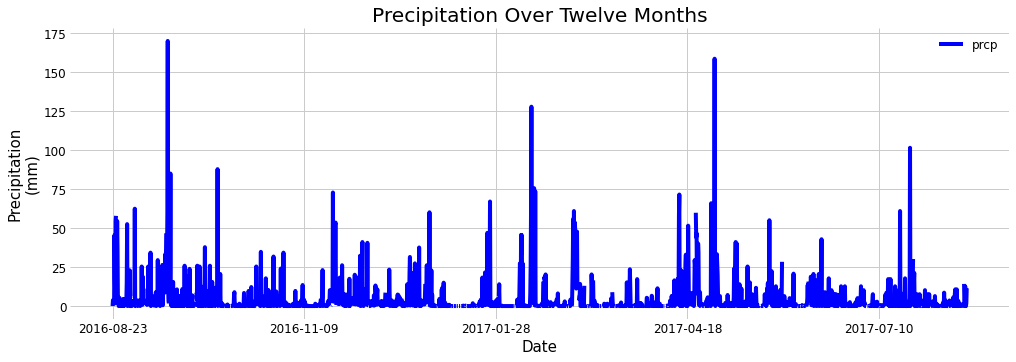

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set
year_back = dt.date(stroptime.year, stroptime.month, stroptime.day) - dt.timedelta(days=365)
print(year_back)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_back).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns=['date', 'prcp']).set_index('date')

# Sort the dataframe by date
precip_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,5))
precip_df.plot(ax=ax, title="Precipitation Over Twelve Months", rot=0, legend=True, fontsize=12, color='blue')
frameon=False
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.xlabel("Date", fontsize=15)
plt.ylabel("Precipitation\n(mm)", fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=12)


In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()


,prcp
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
station_no= session.query(Station.station).count()
print(station_no)


9


In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the most active station id from the previous query
most_active_st_id = most_active[0][0]

# Calculate the lowest, highest, and average temperature
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_st_id).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_st_id).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_st_id).all()

print(f'Lowest temp:  {lowest_temp[0][0]:.1f}')
print(f'Highest temp:  {highest_temp[0][0]:.1f}')
print(f'Average temp:  {avg_temp[0][0]:.1f}')


Lowest temp:  12.2
Highest temp:  29.4
Average temp:  22.0


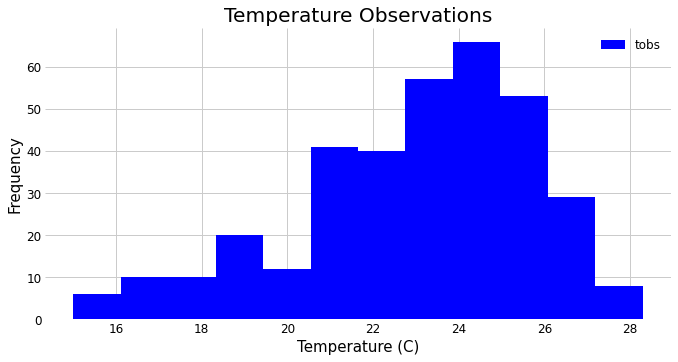

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temp = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_st_id).\
    filter(Measurement.date >= year_back).all()

# Plot the results as a histogram
fig, ax = plt.subplots(figsize=(10,5))
temp_df = pd.DataFrame(temp, columns=['tobs'])
temp_df.plot.hist(bins=12, ax=ax, title="Temperature Observations", legend=True, fontsize=12, color='blue')
frameon=False
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.xlabel("Temperature (C)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.legend(loc='upper right', frameon=False, fontsize=12)


# Close session

In [42]:
# Close Session
session.close()